## Assignment 3: $k$ Nearest Neighbor

**Do two questions.**

`! git clone https://github.com/DS3001/knn`

In [1]:
! git clone https://github.com/DS3001/knn

Cloning into 'knn'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 68 (delta 20), reused 8 (delta 8), pack-reused 39 (from 1)
Receiving objects: 100% (68/68), 13.54 MiB | 8.64 MiB/s, done.
Resolving deltas: 100% (25/25), done.


**Q0.**
1. What is the difference between regression and classification?
- Regression predicts a numeric value, whereas classification predicts a label/category (non-numeric).
2. What is a confusion table? What does it help us understand about a model's performance?
- A confusion table is a matrix that compares the model's predicted values to the actual values. It is an easily digestable way to understand the accuracy level of a model's performance by showing what percentage of the predictions are correct.
3. What does the SSE quantify about a particular model?
- Sum of Squared Error (SSE) quantifies the difference between the predicted value and the actual/observed value.
4. What are overfitting and underfitting?
- Overfitting occurs when a model becomes too specfic to training data, and it cannot accurately predict on test data. Underfitting occurs when a model over-generalizes training data such that it doesnt predict well on training or test data.
5. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or SSE on the test set, improve model performance?
- Splitting the data into two sets improves the performance by ensuring that the model doesn't overfit the data by using exact observations to predict an outcome; rather, it is able to use the training set to create a model that is able to predict on the test set. Choosing $k$ based on SSE alows the model improve by having a $k$ value that minimizes SSE without overfitting.
6. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.
- Reporting as a prediction simplifies the classification, but it should also be reported with a confusion matrix so that the potential error is still available. This will provide more confidence in the prediction rather than just a "blind" classification. Reporting with probability distribution over class labels allows the data scientist to use the model, but still make their own prediction. For example if there is a probability of 51% for Class 1 and 49% for Class 2, the scientist would be able to take context from outside of the model to predict.

**Q6.** This is a case study on $k$ nearest neighbor regression and imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to reduce the dataframe to those variables.
2. Set use `.isnull()` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.
3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.
4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)
5. Predict the missing ratings.
6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Explain why.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [13]:
bnb = pd.read_csv('/content/knn/data/airbnb_hw.csv')
bnb.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [35]:
df = bnb.loc[:, ['Review Scores Rating', 'Price', 'Beds']]
df.rename(columns = {'Review Scores Rating': 'rating', 'Price':'price', 'Beds':'beds'}, inplace = True)
df.head()

,rating,price,beds
0,NaN,145,1.0
1,NaN,37,1.0
2,NaN,28,1.0
3,NaN,199,3.0
4,96.0,549,3.0


In [36]:
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price'].describe()

,price
count,30478.000000
mean,163.589737
std,197.785454
min,10.000000
25%,80.000000
50%,125.000000
75%,195.000000
max,10000.000000


In [53]:
nulls = df[df['rating'].isnull()]
nulls.head()

,rating,price,beds
0,NaN,145,1.0
1,NaN,37,1.0
2,NaN,28,1.0
3,NaN,199,3.0
13,NaN,68,1.0


In [37]:
use = df.dropna(axis = 0, how = 'any')
use.head()

,rating,price,beds
4,96.0,549,3.0
5,100.0,149,1.0
6,100.0,250,1.0
7,94.0,90,1.0
8,90.0,270,2.0


In [38]:
x = use.loc[:, ['price', 'beds']]
y = use.loc[:, 'rating']

In [39]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=300)

In [48]:
k_bar = 200
sse = np.zeros(k_bar)

for k in range(k_bar):
  model = KNeighborsRegressor(n_neighbors=k+1)
  fitted_model = model.fit(X_train, y_train)
  y_hat = fitted_model.predict(X_test)
  sse[k] = (np.sum( (y_test-y_hat)**2 ))
  y_hat_train = fitted_model.predict(X_train)


In [49]:
min_sse = np.min(sse)
min_i = np.where(sse == min_sse)
opt_k = min_i[0]+1
print(opt_k)

[137]


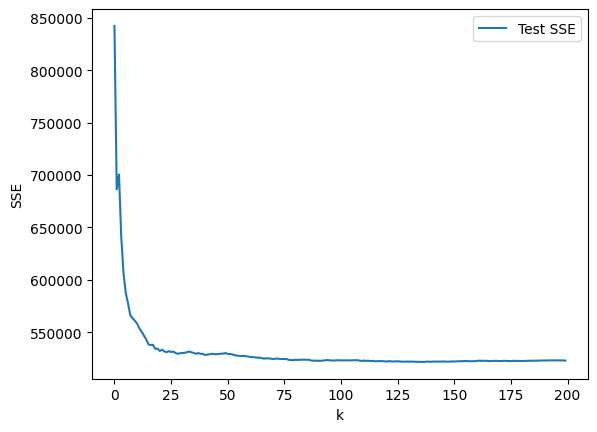

In [50]:
plt.plot(np.arange(0,k_bar),sse,label='Test SSE')
plt.xlabel('k')
plt.ylabel('SSE')
plt.legend(loc = 'upper right')
plt.show()

In [51]:
model = KNeighborsRegressor(n_neighbors=opt_k[0])
fitted_model = model.fit(X_train,y_train)

In [54]:
x_imp = nulls.loc[:,['price','beds'] ]
x_imp = x_imp.dropna(axis=0,how='any')
y_imp = fitted_model.predict(x_imp)

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


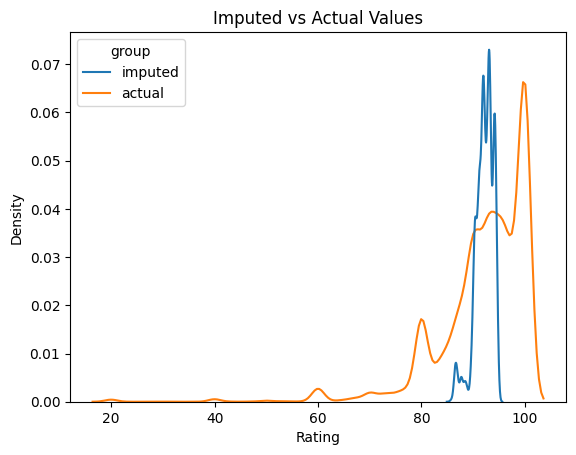

In [63]:
imputed = pd.DataFrame.from_dict({ 'y':y_imp,'group':'imputed'})
true = pd.DataFrame.from_dict({'y':use['rating'],'group':'actual'})
gdf = pd.concat([imputed,true],axis=0)

sns.kdeplot(x='y',hue='group',data=gdf)
plt.title('Imputed vs Actual Values')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

The imputed values only range from 80-100, with a majority density around 90. This is where a majority of the actual data density is, but the actual data has minor spikes in density around 20, 40, 60, and 80, indicating that there are some negative reviews in the real data that are will not be predicted by the model.